# Ejercicio 2

*Tobias Pucci Romero*

### Objetivo: 

Un desafío constante en MELI es el de poder agrupar productos similares utilizando algunos
atributos de estos como pueden ser el título, la descripción o su imagen.
Para este desafío tenemos un dataset "items_titles.csv" que tiene títulos de 30 mil productos
de 3 categorías diferentes de Mercado Libre Brasil

El objetivo del desafío es poder generar una Jupyter notebook que determine cuán similares
son dos títulos del dataset "item_titles_test.csv" generando como output un listado de la
forma:

| ITE_ITEM_TITLE | ITE_ITEM_TITLE | Score Similitud (0,1) |
|----------------|----------------|----------------------|
| Zapatillas Nike| Zapatillas Adidas| 0.5 |
| Zapatillas Nike| Zapatillas Nike | 1.0 |

donde ordenando por score de similitud podamos encontrar los pares de productos más
similares en nuestro dataset de test.


### Imports e installs de librerias

In [ ]:
! pip install --index-url https://pypi.artifacts.furycloud.io \
    replib.descriptors.fasttext-encoders

! pip install scipy

!pip install nltk

!pip install fastparquet

!pip install dask

!pip install pyarrow

!pip install scikit-learn

In [2]:
# Importamos las librerías necesarias
import pandas as pd
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import seaborn as sns
from replib.descriptors.fasttext_encoders import ItemTitleLangModel
import numpy as np
from multiprocessing import cpu_count
from joblib import Parallel, delayed
import os
import dask.dataframe as dd
import nltk
nltk.download('punkt_tab')
import re
import unidecode
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tpucci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tpucci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tpucci/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
# Leemos los archivos CSV
df_train = pd.read_csv('items_titles.csv')
df_test = pd.read_csv('items_titles_test.csv')

print("Tamaño del dataset de entrenamiento:")
print(f"- Número de filas: {len(df_train)}")
print(f"- Número de filas únicas: {df_train['ITE_ITEM_TITLE'].nunique()}")
print(f"- Número de duplicados: {len(df_train) - df_train['ITE_ITEM_TITLE'].nunique()}")
print("\nNumero de nulos:")
print(df_train.isnull().sum())

print("\nTamaño del dataset de test:")
print(f"- Número de filas: {len(df_test)}")


Tamaño del dataset de entrenamiento:
- Número de filas: 30000
- Número de filas únicas: 30000
- Número de duplicados: 0

Numero de nulos:
ITE_ITEM_TITLE    0
dtype: int64

Tamaño del dataset de test:
- Número de filas: 10000


Lo interesante del objetivo es la generacion del csv con ese formato, dado que lo que se pide es un chequeo de similitud de nxn, lo cual nos va a generar un dataset de aproximadamente 50M de filas por lo que el pipeline debe ser modular y escalable.

Veamos brevemente algunas estadísticas de los titulos para ver contra que nos estamos enfrentando 


In [3]:
df_train.head()

,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Verme...
1,Tenis Para Caminhada Super Levinho Spider Corr...
2,Tênis Feminino Le Parc Hocks Black/ice Origina...
3,Tênis Olympikus Esportivo Academia Nova Tendên...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...


In [4]:
# Estadísticas descriptivas de la longitud de los títulos
df_train['longitud_titulo'] = df_train['ITE_ITEM_TITLE'].str.len()
print("\nDataset de entrenamiento:")
print(df_train['longitud_titulo'].describe())


Dataset de entrenamiento:
count    30000.000000
mean        47.033000
std         12.435897
min          3.000000
25%         39.000000
50%         50.000000
75%         57.000000
max        156.000000
Name: longitud_titulo, dtype: float64


Text(0, 0.5, 'Frecuencia')

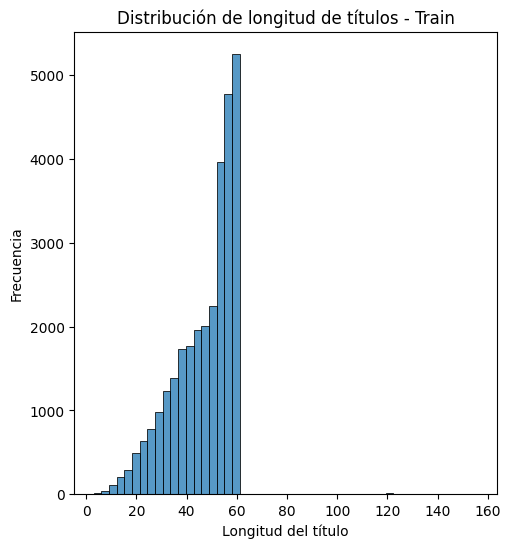

In [5]:
# Visualización de la distribución de longitudes


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='longitud_titulo', bins=50)
plt.title('Distribución de longitud de títulos - Train')
plt.xlabel('Longitud del título')
plt.ylabel('Frecuencia')

Las longitudes se mantienen en un rango aceptable pero parece haber un outlier.

In [6]:
# Calculamos los cuantiles para identificar outliers
print("\nCuantiles de longitud de títulos:")
cuantiles = df_train['longitud_titulo'].quantile([0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 1.0])
print(cuantiles)

# Encontramos el título más largo
titulo_mas_largo = df_train.loc[df_train['longitud_titulo'].idxmax(), 'ITE_ITEM_TITLE']
longitud_maxima = df_train['longitud_titulo'].max()

print(f"\nTítulo más largo ({longitud_maxima} caracteres):")
print(titulo_mas_largo)




Cuantiles de longitud de títulos:
0.25     39.0
0.50     50.0
0.75     57.0
0.90     60.0
0.95     60.0
0.99     60.0
1.00    156.0
Name: longitud_titulo, dtype: float64

Título más largo (156 caracteres):
Mountain Bike Sense Fun Comp 2021/22 2021 Aro 29 L 16v Freios De Disco Hidráulico Câmbios Shimano Altus M315-ts Y Shimano Tourney Tx800 Cor Alumínio/laranja


Aunque sea un outlier, el titulo parece correcto, por lo que no vamos a eliminarlo.

## Pasos a seguir:

El proceso logico para seguir en una tarea como esta sería: 

    1) Procesamiento del texto 
    2) Generación de los embeddings
    3) Calculo de similitud
    4) Generación del output final

## 1era solución sencilla 

Mi primer aproach para generar un baseline de embeddings seria utilizar uno de los modelos de titulos de Replib, por ejemplo el item title lang model (https://rephub.adminml.com/descriptor/item_title_lang_model). Estos estan basados en Fasttext ya entrenados con un corpus gigante de titulos, una solucion que demostro ser muy eficiente para estos casos donde la frecuencia de palabras es mas imporante que la semantica!

En este caso, nos estaríamos salteando el punto 1) y gran parte del 2) dado que no debemos entrenar ningun modelo de generación de embeddings, sino simplemente utilizar el disponible.

Para que estos funcionen de forma optima la diferencia temporal entre su entrenamiento y los titulos en cuestion deben ser minima, no se de que fecha son estos titulos pero asumo que son del presente mas cercano posible asi que utilizo la ultime pre fitted version.

Replib paraleliza internamente por lo que no es necesario hacerlo manualmente. 


In [7]:


# Inicializamos el modelo

PRE_FITTED_VERSION = "MLB_202409_v2_dim100"
descriptor = ItemTitleLangModel(pre_fitted_version=PRE_FITTED_VERSION)

# Generamos los embeddings para los títulos de test
embeddings_test = descriptor.transform(df_test['ITE_ITEM_TITLE'].tolist())

print(f"Forma de los embeddings generados: {embeddings_test.shape}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tpucci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tpucci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-03-12 18:30:28,726 - [WARNING] replib.core.descriptors.base:223 - Descriptor item_title_lang_model was trained with package replib.descriptors.fasttext-encoders==1.8.4 and you have installed replib.descriptors.fasttext-encoders==1.7.1, which may be incompatible.


Forma de los embeddings generados: (10000, 100)


In [8]:
# Agregamos los embeddings al dataframe de test como una única columna
df_test['embeddings'] = embeddings_test.tolist()
print(f"\nShape del DataFrame final: {df_test.shape}")


Shape del DataFrame final: (10000, 2)


In [9]:
df_test.shape

(10000, 2)

#### Calculo de similitud

La metrica mas utilizada y estandar (aunque existen otras) es la similaridad coseno, la practica demuestra que en la mayoria de los casos es suficiente y no tenemos evidencia para probar lo contrario.

Dado que nos encontramos ante un problema de nxn tenemos varias alternativas con tradeoff entre performance y tiempos.

Para precisión alta y dataset mediano:
-  Cosine Similarity con procesamiento por lotes paralelizando
-  Es un buen balance entre precisión y eficiencia

Para escalabilidad extrema:
- Usar FAISS o LSH si necesitas escalar a millones de registros
- Sacrificas algo de precisión pero ganas mucha velocidad


Considerando que nuestro dataset es de 10k filas, podemos hacer un procesamiento por lotes paralelizado y calculas todas las combinaciones excepto las de un titulo contra si mismo, solo appendeo las que tengan una similaridad mayor a 0.5


In [10]:
%%time
def process_chunk(args):
    start_idx, end_idx, titles, embeddings = args
    results = []
    n = len(titles)
    
    for idx1 in range(start_idx, end_idx):
        # Empezamos desde idx1 + 1 para evitar comparar un título consigo mismo
        for idx2 in range(idx1 + 1, n):
            # Verificación adicional para evitar comparaciones duplicadas
            if idx1 != idx2:
                emb1 = embeddings[idx1]
                emb2 = embeddings[idx2]
                similarity = 1 - cosine(emb1, emb2)
                
                if similarity > 0.5:  # umbral ajustable
                    results.append({
                        'title_1': titles[idx1],
                        'title_2': titles[idx2],
                        'similarity_score': similarity
                    })
    return results

def calculate_similarities_joblib(df, output_file='similarities.parquet', n_jobs=-1, batch_size=None):
    """
    Calcula similitudes entre títulos usando procesamiento paralelo con joblib.
    
    Args:
        df: DataFrame con columnas 'ITE_ITEM_TITLE' y 'embeddings'
        output_file: Nombre del archivo parquet de salida
        n_jobs: Número de procesos (-1 para usar todos los cores menos uno)
        batch_size: Tamaño del lote para procesar (None para calcularlo automáticamente)
    """
    n = len(df)
    if batch_size is None:
        batch_size = n // (cpu_count() - 1)
    
    # Preparar los datos
    titles = df['ITE_ITEM_TITLE'].tolist()
    embeddings = np.array(df['embeddings'].tolist())
    
    # Crear el archivo parquet con los headers
    pd.DataFrame(columns=['title_1', 'title_2', 'similarity_score']).to_parquet(output_file)
    
    # Crear los chunks para procesamiento paralelo
    chunks = [
        (i, min(i + batch_size, n), titles, embeddings)
        for i in range(0, n, batch_size)
    ]
    
    # Procesar en paralelo
    print(f"Iniciando procesamiento paralelo con {len(chunks)} chunks...")
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(process_chunk)(chunk_args) for chunk_args in chunks
    )
    
    # Guardar resultados
    total_similarities = 0
    all_results = []
    for i, chunk_results in enumerate(results):
        if chunk_results:
            all_results.extend(chunk_results)
            total_similarities += len(chunk_results)
            print(f"Chunk {i+1}/{len(chunks)} completado - Procesadas {len(chunk_results)} similitudes")
    
    # Guardar todos los resultados en un solo archivo parquet
    if all_results:
        pd.DataFrame(all_results).to_parquet(output_file)
    
    print(f"\nProceso completado. Total de similitudes encontradas: {total_similarities}")
    return total_similarities

# Luego ejecutamos el cálculo de similitudes en paralelo
total_similarities = calculate_similarities_joblib(
    df_test,
    output_file='similarities_1.parquet',
    n_jobs=-1,  # usa todos los cores menos uno
    batch_size=100  # ajusta según tu memoria disponible
)

Iniciando procesamiento paralelo con 100 chunks...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:  1.9min remaining:    4.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


Chunk 1/100 completado - Procesadas 886450 similitudes
Chunk 2/100 completado - Procesadas 878290 similitudes
Chunk 3/100 completado - Procesadas 889617 similitudes
Chunk 4/100 completado - Procesadas 858392 similitudes
Chunk 5/100 completado - Procesadas 881887 similitudes
Chunk 6/100 completado - Procesadas 830952 similitudes
Chunk 7/100 completado - Procesadas 807470 similitudes
Chunk 8/100 completado - Procesadas 804240 similitudes
Chunk 9/100 completado - Procesadas 829394 similitudes
Chunk 10/100 completado - Procesadas 807816 similitudes
Chunk 11/100 completado - Procesadas 782199 similitudes
Chunk 12/100 completado - Procesadas 805124 similitudes
Chunk 13/100 completado - Procesadas 794065 similitudes
Chunk 14/100 completado - Procesadas 758986 similitudes
Chunk 15/100 completado - Procesadas 776281 similitudes
Chunk 16/100 completado - Procesadas 743396 similitudes
Chunk 17/100 completado - Procesadas 727544 similitudes
Chunk 18/100 completado - Procesadas 717088 similitudes
C

In [12]:
# Para no tener que cargar todo el dataset en memoria podemos utilizar dask de forma de ver las similaridades mayores de forma eficiente y rapida 

def read_large_parquet_efficiently(parquet_file, n_partitions=None):
    """
    Lee un archivo parquet pesado de manera eficiente usando dask.
    
    Args:
        parquet_file: Ruta al archivo parquet
        n_partitions: Número de particiones (opcional)
    """
    # Leer el parquet con dask
    ddf = dd.read_parquet(parquet_file)
    
    if n_partitions:
        ddf = ddf.repartition(npartitions=n_partitions)

    return ddf

# Cargar el parquet de manera eficiente
ddf = read_large_parquet_efficiently('similarities_1.parquet', n_partitions=4)

# Ver solo las similitudes más altas sin cargar todo el archivo
top_similarities = ddf.nlargest(30, 'similarity_score').compute()
print("\nTop 10 similitudes:")
print(top_similarities)



Top 10 similitudes:
                                                    title_1  \
4168153                                    Tenis D&g Milano   
4815936                  Tênis Converse All Star Cano Alto    
5553969                                     Tênis - Schutz    
6972990         Mountain Bike 29 Dropp 27v Freio Hidraulico   
7542256               Tênis Olympikus Saga Feminino Marinho   
8584223   Tv Portátil Tomate Mtm-808 Led  8 Polegadas 10...   
13918473                                     Tênis Slip On    
15707763                   Tenis Olympikus Vortex Masculino   
18718071  Tênis Feminino Flatform Espadrille Beira Rio -...   
22060998                   Tênis Sapatênis Masculino Casual   
23055248  Sapatênis Tênis Masculino Couro Legítimo Cano ...   
24048464                                  Tenis De Basquete   
24899521  Tênis Mvp Cross Training - Cross, Academia, Fu...   
24913053  Bicicleta  Feminin Infantil Nathor Top Girls A...   
33251197     Sapatenis Masculino D

In [13]:
top_similarities

,title_1,title_2,similarity_score
4168153,Tenis D&g Milano,Tenis D & G Milano,1.0
4815936,Tênis Converse All Star Cano Alto,Tênis Converse All Star Cano Alto,1.0
5553969,Tênis - Schutz,Tênis Schutz.,1.0
6972990,Mountain Bike 29 Dropp 27v Freio Hidraulico,Mountain Bike 29 Dropp 27v Freio Hidraulico,1.0
7542256,Tênis Olympikus Saga Feminino Marinho,Tênis Olympikus Saga Feminino - Marinho,1.0
8584223,Tv Portátil Tomate Mtm-808 Led 8 Polegadas 10...,Tv Portátil Tomate Mtm-808 Led 8 Polegadas 100...,1.0
13918473,Tênis Slip On,Tênis Slip On,1.0
15707763,Tenis Olympikus Vortex Masculino,Tênis Olympikus Vortex - Masculino,1.0
18718071,Tênis Feminino Flatform Espadrille Beira Rio -...,Tênis Feminino Flatform Espadrille Beira Rio 4...,1.0
22060998,Tênis Sapatênis Masculino Casual,Sapatênis Tênis Masculino Casual,1.0


Por lo que podemos observar las similitudes hacen completo sentido, las diferencias son minimsas o nulas

## 2da solución completa

Para no perder parte de la escencia del ejercicio, puedo realizar otro approach sencillo pero conceptual de como hacerlo desde cero. Para esto usaré un metodo simple pero poderoso, TF-IDF, considerando que ya utilicé uno mas complejo como lo es Fasttext. 

Para esto primero debo limpiar los textos como lo considere necesario. En este caso, los titulos de meli ya se encuentran depurados en cierta medida por lo que solo realizare ciertas modificaciones puntuales. 

In [32]:
df_test = pd.read_csv('items_titles_test.csv')


stop_words = set(stopwords.words('portuguese'))  

def clean_text(text):
    text = text.lower()
    text = unidecode.unidecode(text)
    text = re.sub(r'[^a-z0-9\s\-\_\$\%\&\#\@\!]', '', text)  # Letras, números y caracteres especiales permitidos
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

# Aplicar la función a cada título
df_train['clean_title'] = df_train['ITE_ITEM_TITLE'].apply(clean_text)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tpucci/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


De esta forma eliminamos puntuacion y mayusculas de forma de homogeneizar los textos para generar menos tokens en el entrenamiento del TF-IDF para generalizar mejor. 

In [33]:
df_train.head()

,ITE_ITEM_TITLE,longitud_titulo,clean_title
0,Tênis Ascension Posh Masculino - Preto E Verme...,50,tenis ascension posh masculino - preto vermelho
1,Tenis Para Caminhada Super Levinho Spider Corr...,50,tenis caminhada super levinho spider corrida
2,Tênis Feminino Le Parc Hocks Black/ice Origina...,56,tenis feminino le parc hocks blackice original...
3,Tênis Olympikus Esportivo Academia Nova Tendên...,58,tenis olympikus esportivo academia nova tenden...
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicl...,59,inteligente led bicicleta tauda luz usb bicicl...


In [34]:
# Ahora entrenemos el modelo con nuestro dataset de entrenamiento y generaremos los embeddings para los titulos de test
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit(df_train['clean_title'])


# Limpiamos los títulos de test
df_test['clean_title'] = df_test['ITE_ITEM_TITLE'].apply(clean_text)

# Generamos los embeddings usando el vectorizador entrenado
test_embeddings = vectorizer.transform(df_test['clean_title'])

# Convertimos la matriz sparse a un array denso
test_embeddings_dense = test_embeddings.toarray()

# Agregamos los embeddings como una columna al dataframe de test
df_test['title_embedding'] = test_embeddings_dense.tolist()


In [35]:
df_test

,ITE_ITEM_TITLE,clean_title,title_embedding
0,Tênis Olympikus Esporte Valente - Masculino Kids,tenis olympikus esporte valente - masculino kids,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Bicicleta Barra Forte Samy C/ 6 Marchas Cubo C...,bicicleta barra forte samy c 6 marchas cubo c ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Tênis Usthemp Slip-on Temático - Labrador 2,tenis usthemp slip-on tematico - labrador 2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Tênis Casual Feminino Moleca Tecido Tie Dye,tenis casual feminino moleca tecido tie dye,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Tênis Star Baby Sapatinho Conforto + Brinde,tenis star baby sapatinho conforto brinde,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
9995,Chuteira Futsal Oxn Velox 3 Infantil,chuteira futsal oxn velox 3 infantil,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9996,Sapatenis Casual Masculino Estiloso 24horas Co...,sapatenis casual masculino estiloso 24horas co...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9997,Tênis Feminino Infantil Molekinha Tie Dye,tenis feminino infantil molekinha tie dye,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,Tênis Feminino Leve Barato Ganhe 1 Colchonete ...,tenis feminino leve barato ganhe 1 colchonete ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Los embbedings parecen que son completamente cero por el funcionamiento del tf idf y su comportamiento esparso, pero corroboremos que no lo son. 

In [38]:
# Verificar si hay embeddings que no sean todo cero
embeddings_no_cero = df_test['title_embedding'].apply(lambda x: not all(v == 0 for v in x))
print(f"\nNúmero de embeddings que no son todo cero: {embeddings_no_cero.sum()}")
print(f"Porcentaje de embeddings no-cero: {(embeddings_no_cero.sum()/len(df_test))*100:.2f}%")



Número de embeddings que no son todo cero: 9995
Porcentaje de embeddings no-cero: 99.95%


#### Realicemos el mismo proceso de calculo de similaridad con los nuevos embeddings


In [42]:
%%time
def process_chunk(args):
    start_idx, end_idx, titles, embeddings = args
    results = []
    n = len(titles)
    
    for idx1 in range(start_idx, end_idx):
        # Empezamos desde idx1 + 1 para evitar comparar un título consigo mismo
        for idx2 in range(idx1 + 1, n):
            # Verificación adicional para evitar comparaciones duplicadas
            if idx1 != idx2:
                emb1 = embeddings[idx1]
                emb2 = embeddings[idx2]
                similarity = 1 - cosine(emb1, emb2)
                
                if similarity > 0.5:  # umbral ajustable
                    results.append({
                        'title_1': titles[idx1],
                        'title_2': titles[idx2],
                        'similarity_score': similarity
                    })
    return results
    
def calculate_similarities_joblib(df, output_file='similarities.parquet', n_jobs=-1, batch_size=None):
    """
    Calcula similitudes entre títulos usando procesamiento paralelo con joblib.
    
    Args:
        df: DataFrame con columnas 'ITE_ITEM_TITLE' y 'embeddings'
        output_file: Nombre del archivo parquet de salida
        n_jobs: Número de procesos (-1 para usar todos los cores menos uno)
        batch_size: Tamaño del lote para procesar (None para calcularlo automáticamente)
    """
    n = len(df)
    if batch_size is None:
        batch_size = n // (cpu_count() - 1)
    
    # Preparar los datos
    titles = df['ITE_ITEM_TITLE'].tolist()
    embeddings = np.array(df['title_embedding'].tolist())
    
    # Crear el archivo parquet con los headers
    pd.DataFrame(columns=['title_1', 'title_2', 'similarity_score']).to_parquet(output_file)
    
    # Crear los chunks para procesamiento paralelo
    chunks = [
        (i, min(i + batch_size, n), titles, embeddings)
        for i in range(0, n, batch_size)
    ]
    
    # Procesar en paralelo
    print(f"Iniciando procesamiento paralelo con {len(chunks)} chunks...")
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(process_chunk)(chunk_args) for chunk_args in chunks
    )
    
    # Guardar resultados
    total_similarities = 0
    all_results = []
    for i, chunk_results in enumerate(results):
        if chunk_results:
            all_results.extend(chunk_results)
            total_similarities += len(chunk_results)
            print(f"Chunk {i+1}/{len(chunks)} completado - Procesadas {len(chunk_results)} similitudes")
    
    # Guardar todos los resultados en un solo archivo parquet
    if all_results:
        pd.DataFrame(all_results).to_parquet(output_file)
    
    print(f"\nProceso completado. Total de similitudes encontradas: {total_similarities}")
    return total_similarities

# Luego ejecutamos el cálculo de similitudes en paralelo
total_similarities = calculate_similarities_joblib(
    df_test,
    output_file='similarities_2.parquet',  # Cambiado para reflejar que son similitudes TF-IDF
    n_jobs=-1,  # usa todos los cores menos uno
    batch_size=100  # ajusta según tu memoria disponible
)

Iniciando procesamiento paralelo con 100 chunks...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/tpucci/.pyenv/versions/3.12.9/envs/challenge_tomas/lib/python3.12/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
/Users/tpucci/.pyenv/versions/3.12.9/envs/challenge_tomas/lib/python3.12/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
/Users/tpucci/.pyenv/versions/3.12.9/envs/challenge_tomas/lib/python3.12/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
/Users/tpucci/.pyenv/versions/3.12.9/envs/challenge_tomas/lib/python3.12/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)
/Users/tpucci/.pyenv/versions/3.12.9/envs/challenge_tomas/li

Chunk 1/100 completado - Procesadas 583 similitudes
Chunk 2/100 completado - Procesadas 684 similitudes
Chunk 3/100 completado - Procesadas 466 similitudes
Chunk 4/100 completado - Procesadas 453 similitudes
Chunk 5/100 completado - Procesadas 445 similitudes
Chunk 6/100 completado - Procesadas 443 similitudes
Chunk 7/100 completado - Procesadas 520 similitudes
Chunk 8/100 completado - Procesadas 519 similitudes
Chunk 9/100 completado - Procesadas 542 similitudes
Chunk 10/100 completado - Procesadas 579 similitudes
Chunk 11/100 completado - Procesadas 459 similitudes
Chunk 12/100 completado - Procesadas 405 similitudes
Chunk 13/100 completado - Procesadas 451 similitudes
Chunk 14/100 completado - Procesadas 420 similitudes
Chunk 15/100 completado - Procesadas 466 similitudes
Chunk 16/100 completado - Procesadas 444 similitudes
Chunk 17/100 completado - Procesadas 531 similitudes
Chunk 18/100 completado - Procesadas 603 similitudes
Chunk 19/100 completado - Procesadas 397 similitudes
Ch

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.7min finished


In [45]:
# Cargar el parquet de manera eficiente
ddf_2 = read_large_parquet_efficiently('similarities_2.parquet', n_partitions=4)

# Ver solo las similitudes más altas sin cargar todo el archivo
top_similarities_2 = ddf_2.nlargest(30, 'similarity_score').compute()
print("\nTop 30 similitudes:")
top_similarities_2


Top 30 similitudes:


,title_1,title_2,similarity_score
118,Tênis Skechers M Go Walk Evolution Ultra,Tênis Skechers Go Walk Evolution Ultra,1.0
280,Tênis Branco Feminino Confortável,Tênis Feminino Branco Confortável,1.0
839,Tênis Coca Cola Cc1862,Tênis Coca Cola,1.0
1062,Tênis Freeday Bio - Preto/laranja,Tenis Freeday Bio Preto/laranja Neon/preto - 7...,1.0
1145,Tênis Feminino Slip On Veroffato 6011002,Tênis Feminino Slip On Veroffato 6011003,1.0
1207,Tênis Feminino Mizuno Wave Prime 9 -lançamento...,Tênis Feminino Mizuno Wave Prime 9 Lançamento ...,1.0
1352,5 Pares Tênis Masculino Leve Para Caminhada Pr...,3 Pares Tênis Masculino Leve Para Caminhada Pr...,1.0
1988,Tênis adidas Strutter Eg5140,Tênis adidas Nitrocharge,1.0
1992,Tênis adidas Strutter Eg5140,Tenis adidas Extaball W B35351,1.0
1994,Tênis adidas Strutter Eg5140,Tênis adidas Torsion,1.0


Podemos ver que los titulos son tambien muy parecidos, pero a simble vista parece que el otro modelo es mejor, en ciertos casos aca se esta olvidando de caracteres y codigo puntuales, lo cual tiene sentido dado el approach de n-gramas de Fastext. Esto podriamos mejorarlo optimizando la limipieza de datos y modificando los hiperparametros del tfid